In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import lxml
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from ripser import ripser
from persim import plot_diagrams
import gudhi as gd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel

In [112]:
sp500 = list(pd.read_csv('sp500_companies.csv')['Symbol'])

In [113]:
for tick in ['ANSS', 'DFS', 'JNPR', 'WBA', 'HES', 'PARA', 'GEV']:
    sp500.remove(tick)

In [83]:
# prices = yf.download(
#     sp500,
#     start="2025-01-01",
#     end="2025-12-31"
# )["Close"]
# prices = prices.ffill()
# returns = prices.pct_change().dropna()
# returns.head()
# # Correlation matrix
# corr = returns.corr().values

# # Convert correlation to distance for weights
# dist = np.sqrt(2 * (1 - corr))
# np.fill_diagonal(dist, 0)
# G = nx.Graph()

# # Add nodes
# for i, ticker in enumerate(sp500):
#     G.add_node(i, label=ticker)

# # Add edges with correlation weights
# for i in range(len(sp500)):
#     for j in range(i+1, len(sp500)):
#         # Higher correlation → stronger connection → smaller distance → weight = corr
#         G.add_edge(i, j, weight=corr[i, j])

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import networkx as nx

# Stock tickers
tickers = sp500[:250]

# Download data
data = yf.download(tickers, start="2022-01-01", end="2024-01-01")["Close"]

# Drop missing rows
data = data.dropna(how='any')

# Daily log returns
returns = np.log(data / data.shift(1)).dropna(how='any')

# Correlation matrix
corr = returns.corr().values


[*********************100%***********************]  250 of 250 completed


In [ ]:
def spectral_clustering_with_threshold(corr_matrix, threshold, n_clusters):
    G = nx.Graph()
    for i, ticker in enumerate(tickers):
        G.add_node(i, label=ticker)

    for i in range(len(tickers)):
        for j in range(i+1, len(tickers)):
            if corr_matrix[i, j] >= threshold:
                G.add_edge(i, j, weight=corr_matrix[i, j])
                
    node_features = []

    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        subgraph = G.subgraph(neighbors + [node])

        degree = G.degree(node)
        strength = sum([G[node][nbr]['weight'] for nbr in neighbors])
        clustering = nx.clustering(G, node, weight='weight')
        loops = sum(1 for cycle in nx.cycle_basis(subgraph) if node in cycle)

        node_features.append([degree, strength, clustering, loops])

    node_features = np.array(node_features)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(node_features)

    # Create similarity matrix using RBF kernel
    similarity_matrix = rbf_kernel(X_scaled, gamma=0.5)

    # Spectral clustering
    sc = SpectralClustering(
        n_clusters=n_clusters,
        affinity='precomputed',
        assign_labels='kmeans',
        random_state=42
    )
    labels = sc.fit_predict(similarity_matrix)
    
    plt.figure(figsize=(15, 12))
    pos = nx.spring_layout(G, seed=42, k=0.5)

    node_sizes = 500 + 25 * node_features[:,3]  # loop count
    node_colors = labels  # cluster color

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Set2)

    # Draw edges with correlation weight as thickness
    edges = G.edges(data=True)
    nx.draw_networkx_edges(
        G, pos,
        width=[4 * abs(d['weight']) for (_, _, d) in edges],  # use abs to scale thickness
        alpha=0.6
    )

    # Draw labels
    nx.draw_networkx_labels(G, pos, labels={i: tickers[i] for i in range(len(tickers))})

    plt.title("Correlation-Weighted Stock Graph with Spectral Clustering")
    plt.axis('off')
    plt.show()
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(node_features)
    
    plt.figure(figsize=(12,9))

    # Scatter plot, colored by cluster
    for cluster_id in np.unique(labels):
        idx = labels == cluster_id
        plt.scatter(
            X_pca[idx,0],
            X_pca[idx,1],
            label=f'Cluster {cluster_id}',
            s=300,
            alpha=0.7
        )

    # Annotate with tickers
    for i, ticker in enumerate(tickers):
        plt.text(X_pca[i,0]+0.02, X_pca[i,1]+0.02, ticker, fontsize=9)

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Stock Graph Features Projected via PCA")
    plt.legend()
    plt.grid(True)
    plt.show()


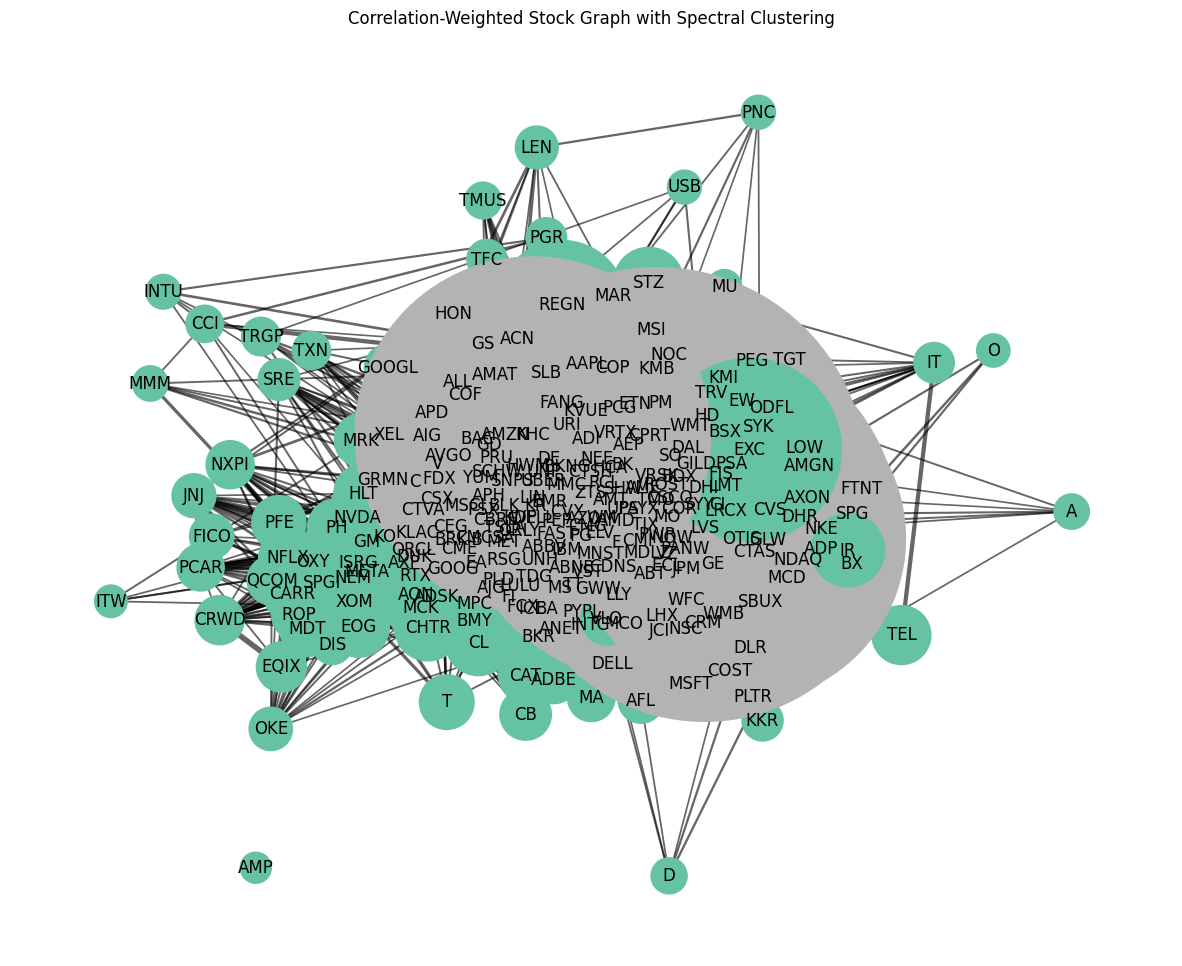

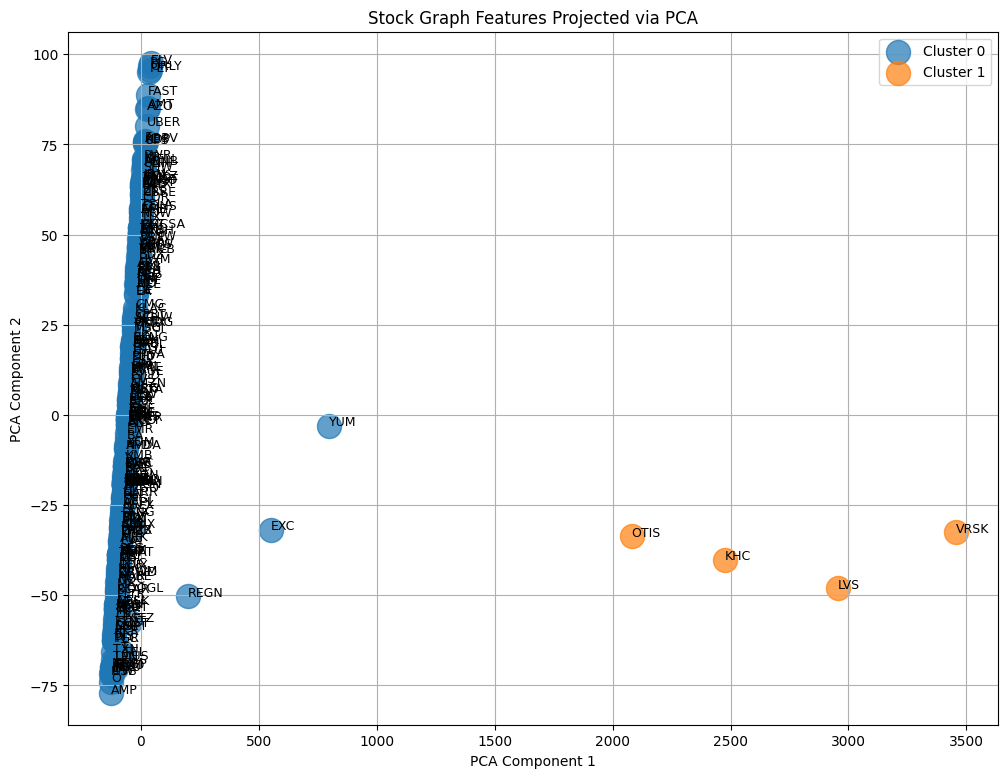

In [221]:
spectral_clustering_with_threshold(corr, threshold=0.3, n_clusters=2)

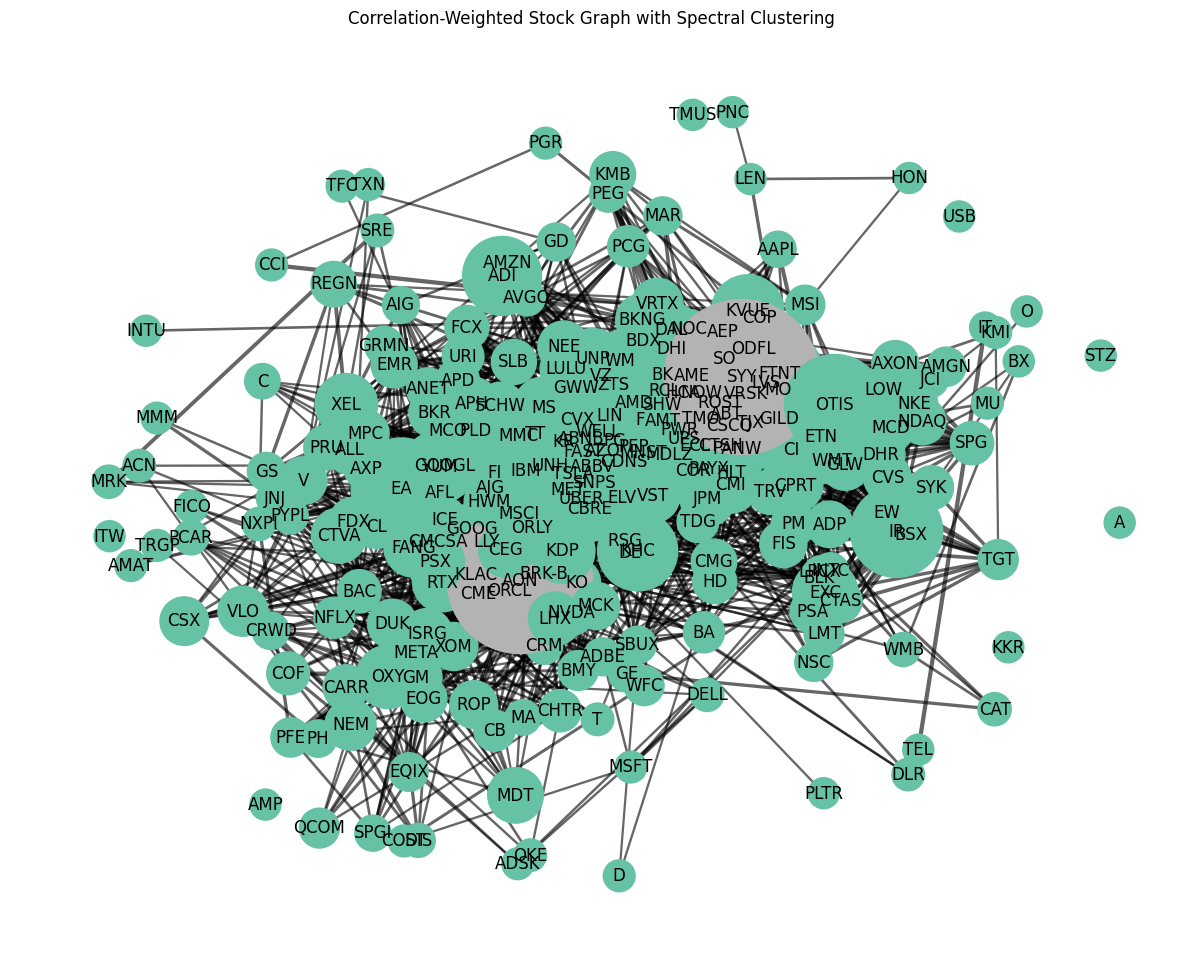

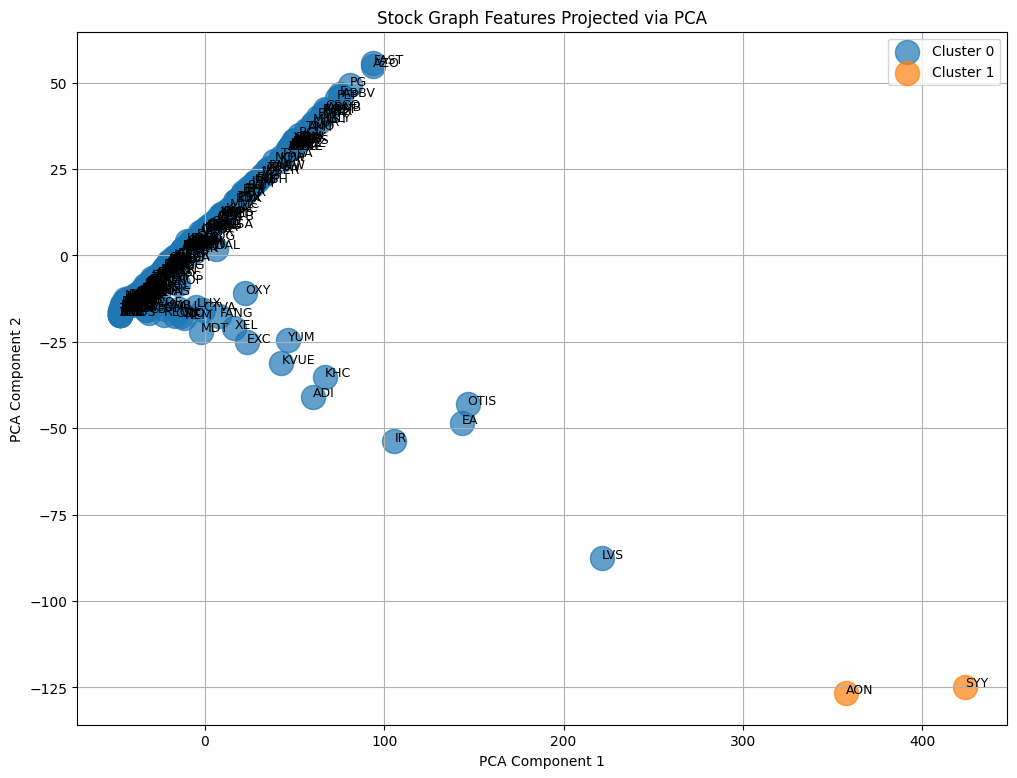

In [220]:
spectral_clustering_with_threshold(corr, threshold=0.4, n_clusters=2)

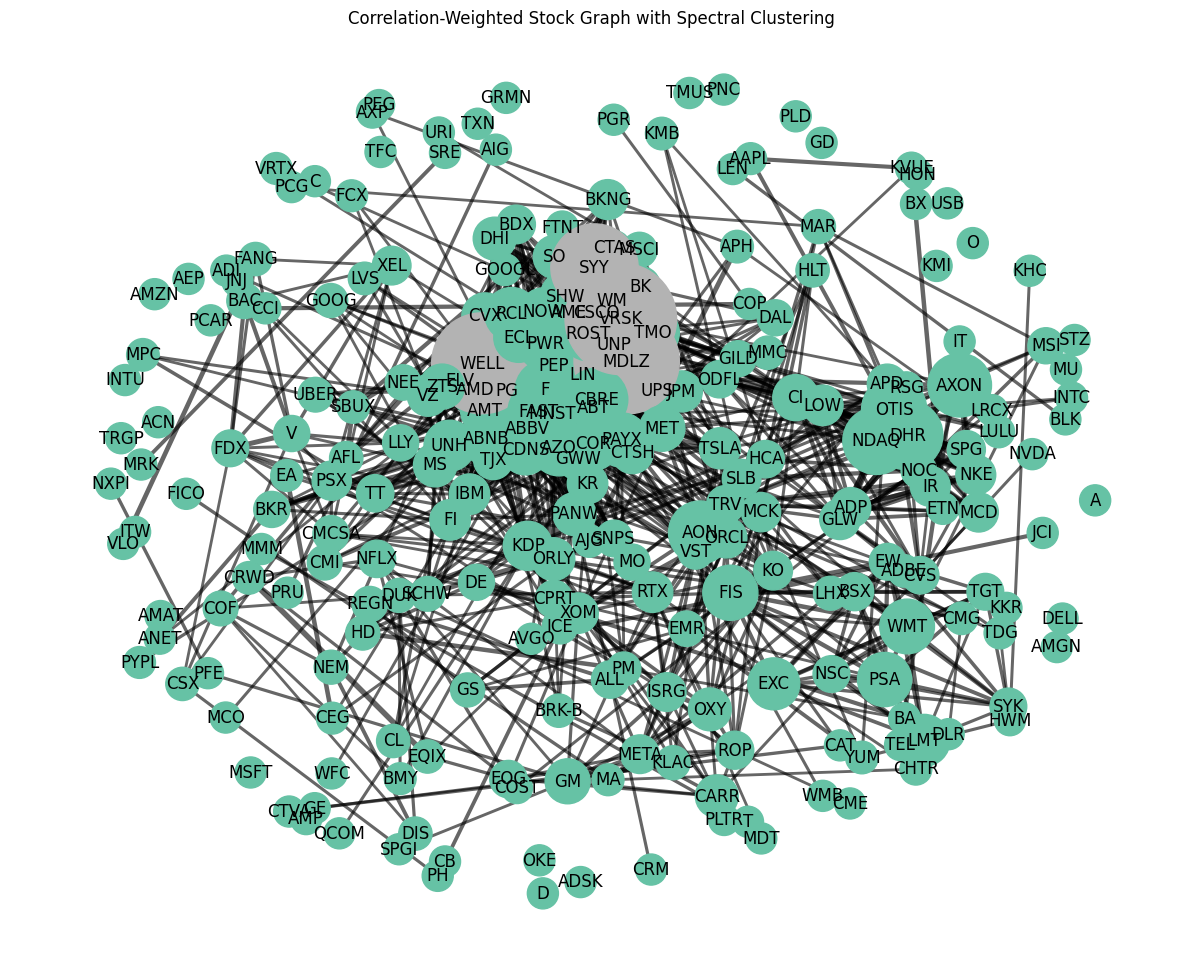

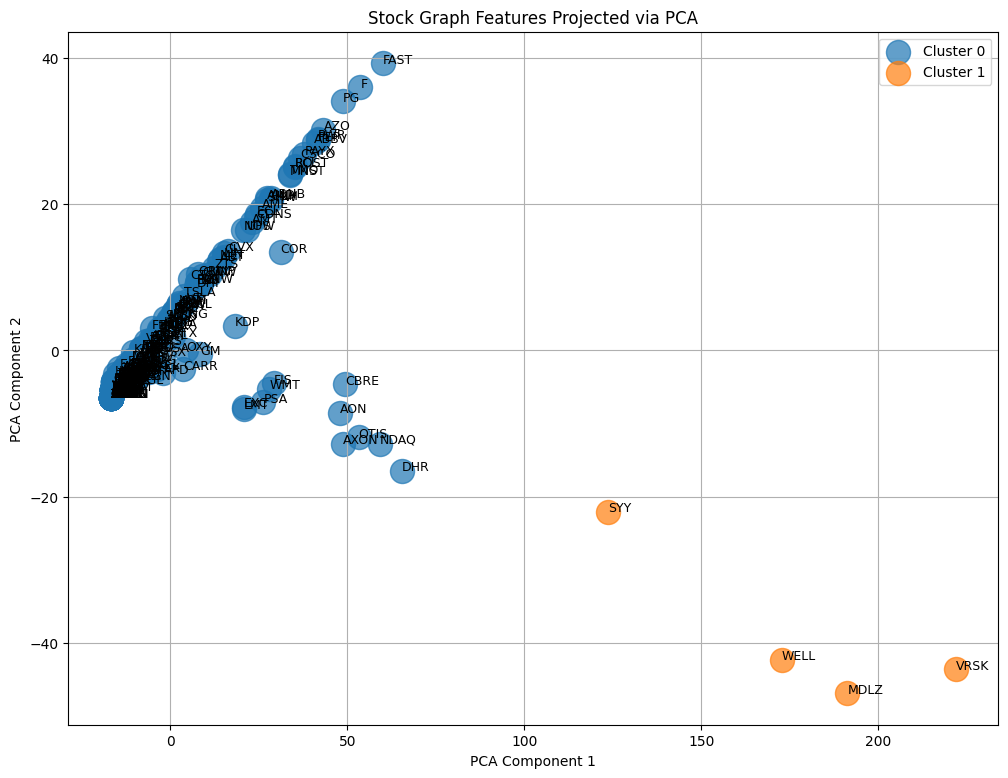

In [218]:
spectral_clustering_with_threshold(corr, threshold=0.5, n_clusters=2)

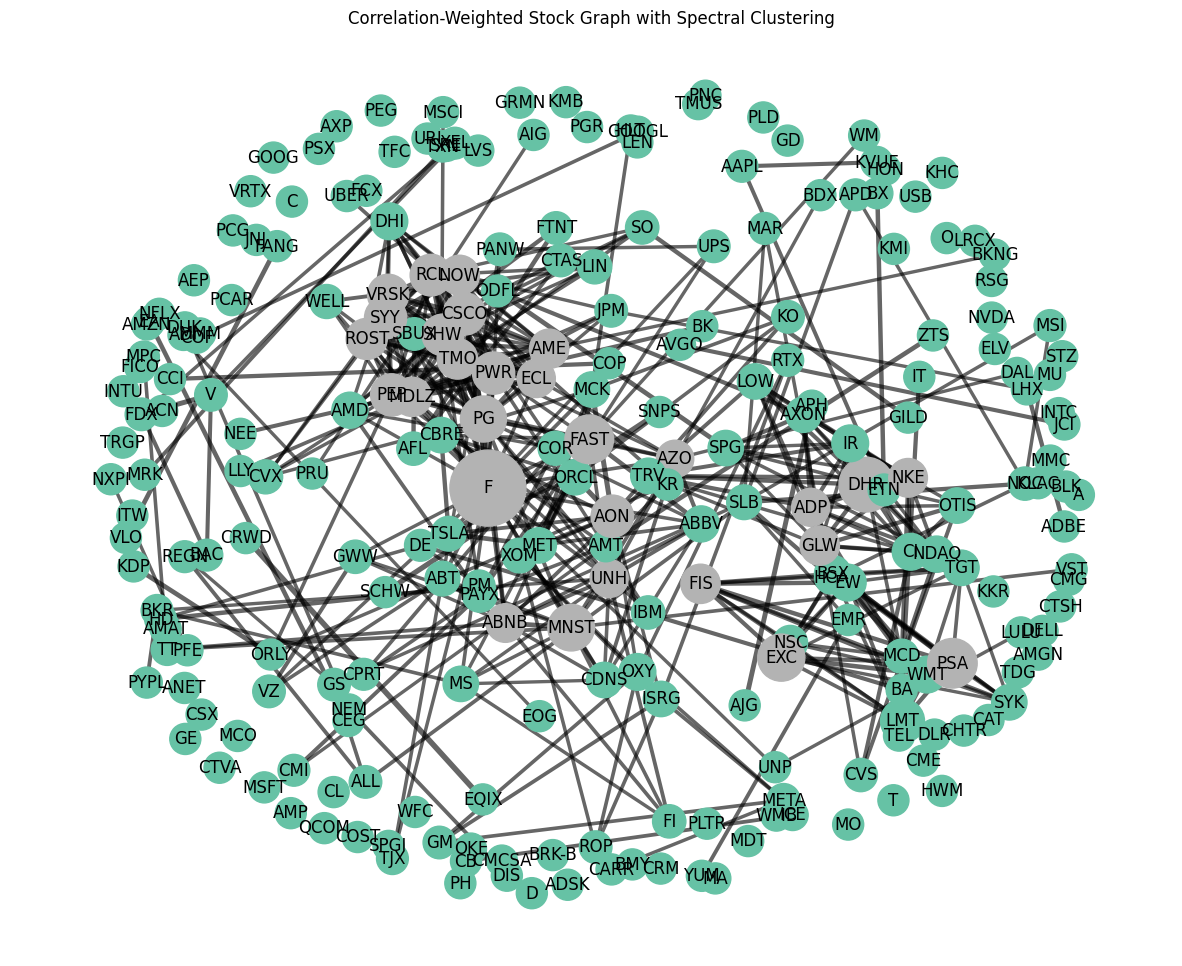

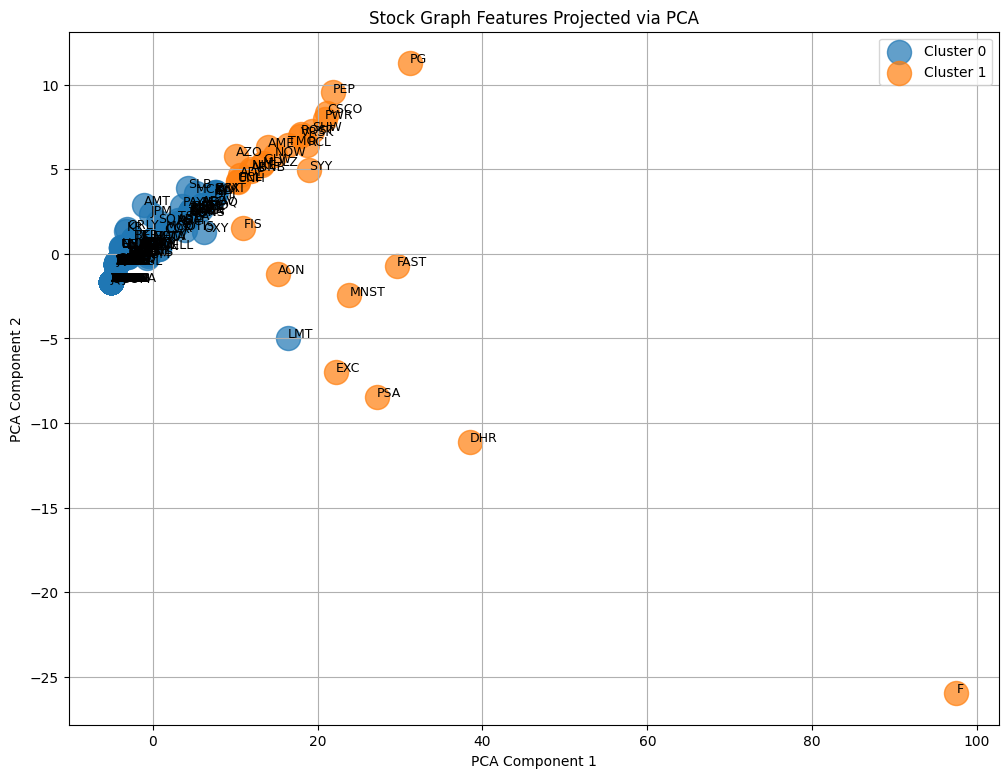

In [217]:
spectral_clustering_with_threshold(corr, threshold=0.6, n_clusters=2)

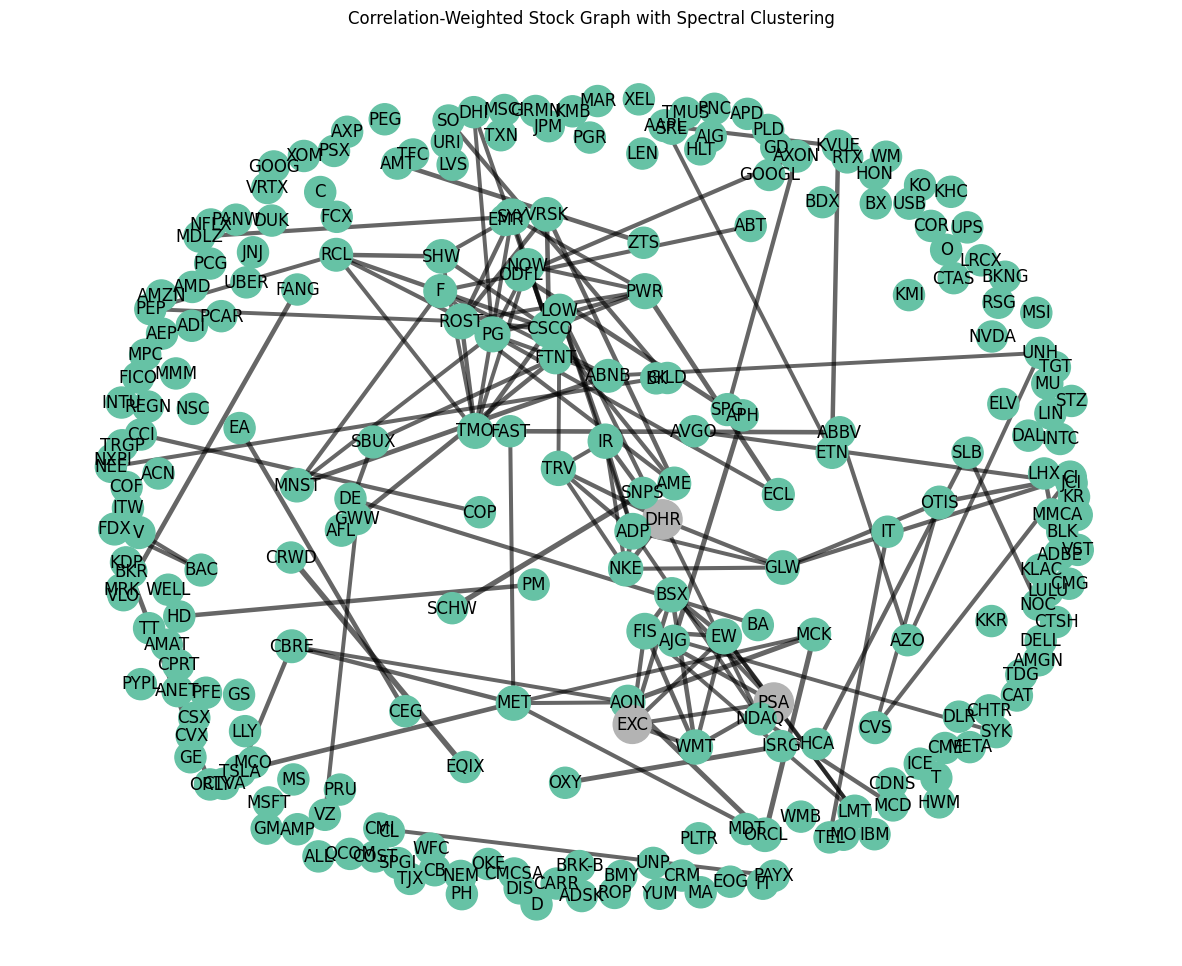

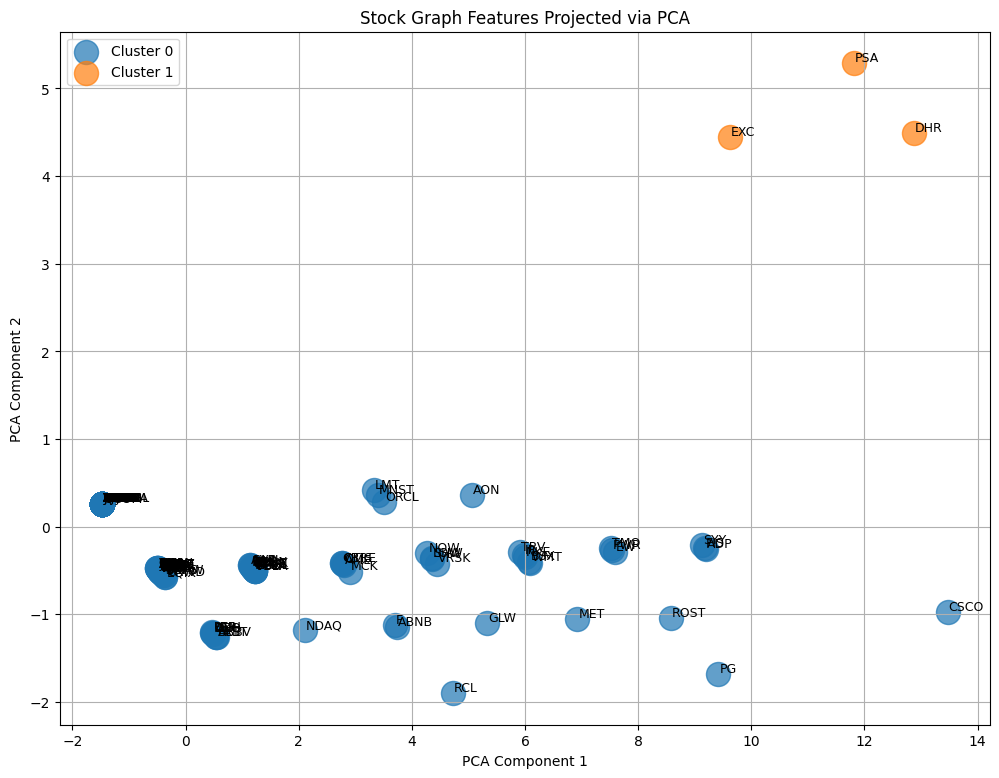

In [219]:
spectral_clustering_with_threshold(corr, threshold=0.7, n_clusters=2)

In [ ]:
# add topological features from the graph and apply clustering again. does it improve?